In [22]:
#PyTorch
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Math
import math

# Matplotlib
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
plt.style.use('fivethirtyeight')

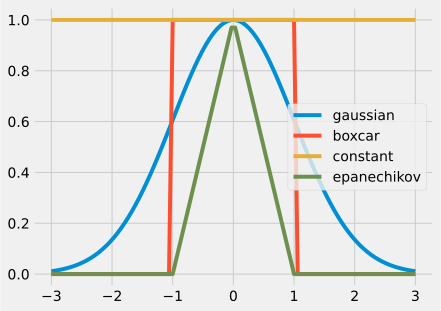

In [9]:
# Define some kernels
def gaussian(x):
    return torch.exp(-x**2 / 2)

def boxcar(x):
    return torch.abs(x) < 1.0

def constant(x):
    return 1.0 + 0 * x

def epanechikov(x):
    return torch.max(1 - torch.abs(x), torch.zeros_like(x))


x = torch.linspace(-3,3,100)

plt.plot(x, gaussian(x), label="gaussian")
plt.plot(x, boxcar(x), label="boxcar")
plt.plot(x, constant(x), label="constant")
plt.plot(x, epanechikov(x), label="epanechikov")


plt.legend()


In [20]:
def f(x):
    return 2 * torch.sin(x) + x

n = 40
x_train, _ = torch.sort(torch.rand(n) * 5)
y_train = f(x_train) + torch.randn(n)
x_val = torch.arange(0, 5, 0.1)
y_val = f(x_val)

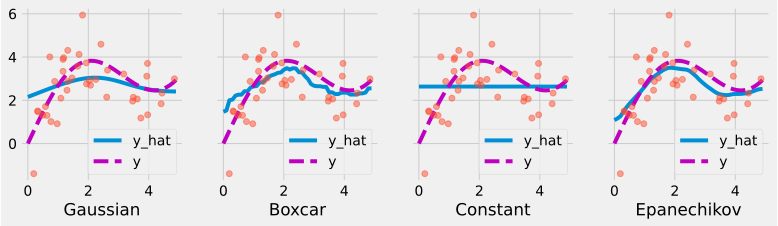

In [21]:
def nadaraya_watson(x_train, y_train, x_val, kernel):
    dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
    # Each column/row corresponds to each query/key
    k = kernel(dists).type(torch.float32)
    attention_w = k / k.sum(0)  # Normalization over keys for each query
    y_hat = y_train@attention_w
    return y_hat, attention_w


def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
    fig, axes = plt.subplots(1, 4, sharey=True, figsize=(12, 3))
    for kernel, name, ax in zip(kernels, names, axes):
        y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, kernel)
        if attention:
            pcm = ax.imshow(attention_w.detach().numpy(), cmap='Reds')
        else:
            ax.plot(x_val, y_hat)
            ax.plot(x_val, y_val, 'm--')
            ax.plot(x_train, y_train, 'o', alpha=0.5);
        ax.set_xlabel(name)
        if not attention:
            ax.legend(['y_hat', 'y'])
    if attention:
        fig.colorbar(pcm, ax=axes, shrink=0.7)

kernels = (gaussian, boxcar, constant, epanechikov)
names = ('Gaussian', 'Boxcar', 'Constant', 'Epanechikov')
plot(x_train, y_train, x_val, y_val, kernels, names)



In [23]:
def masked_softmax(X, valid_lens):
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

In [65]:
X = torch.randn((4,4))
maxlen = X.size(1)
lens = torch.tensor([1, 2, 3, 4])


mask = torch.arange((maxlen))[None, :]  < lens[:, None]

X.size(1), maxlen, mask[None, :], lens[:, None]

print (mask.shape)
X[~mask] = -1e6


#lens = torch.tensor([2, 3])

#lens, torch.repeat_interleave(lens, X.shape[1]), lens.reshape(-1)

nn.functional.softmax(X, dim=0)


torch.Size([4, 4])


tensor([[0.1500, 0.0000, 0.0000, 0.0000],
        [0.1272, 0.0038, 0.0000, 0.0000],
        [0.6168, 0.7804, 0.9019, 0.0000],
        [0.1059, 0.2158, 0.0981, 1.0000]])

In [66]:
def masked_softmax(X, valid_lens):  #@save
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [67]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.3357, 0.6643, 0.0000, 0.0000],
         [0.5331, 0.4669, 0.0000, 0.0000]],

        [[0.4208, 0.2852, 0.2940, 0.0000],
         [0.3531, 0.3336, 0.3133, 0.0000]]])

In [72]:
Q = torch.ones((2, 3, 4))
K = torch.ones((2, 4, 6))

X = Q @ K

Q.shape, K.shape, X.shape

(torch.Size([2, 3, 4]), torch.Size([2, 4, 6]), torch.Size([2, 3, 6]))

In [76]:
class AdditiveAttention(nn.Module):  #@save
    """Additive attention."""
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of queries: (batch_size, no. of
        # queries, 1, num_hiddens) and shape of keys: (batch_size, 1, no. of
        # key-value pairs, num_hiddens). Sum them up with broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # There is only one output of self.w_v, so we remove the last
        # one-dimensional entry from the shape. Shape of scores: (batch_size,
        # no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of values: (batch_size, no. of key-value pairs, value
        # dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [77]:
class AttentionDecoder(nn.Module):  #@save
    """The base attention-based decoder interface."""
    def __init__(self):
        super().__init__()

    @property
    def attention_weights(self):
        raise NotImplementedError

In [84]:
def init_seq2seq(module):  #@save
    """Initialize weights for Seq2Seq."""
    if type(module) == nn.Linear:
         nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.GRU:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])


class Encoder(nn.Module):  #@save
    """The base encoder interface for the encoder-decoder architecture."""
    def __init__(self):
        super().__init__()

    # Later there can be additional arguments (e.g., length excluding padding)
    def forward(self, X, *args):
        raise NotImplementedError


class Decoder(nn.Module):  #@save
    """The base decoder interface for the encoder-decoder architecture."""
    def __init__(self):
        super().__init__()

    # Later there can be additional arguments (e.g., length excluding padding)
    def init_state(self, enc_all_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError


class EncoderDecoder(nn.Module):  #@save
    """The base class for the encoder-decoder architecture."""
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_all_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_all_outputs, *args)
        # Return decoder output only
        return self.decoder(dec_X, dec_state)[0]

class Seq2SeqEncoder(Encoder):  #@save
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout)
        self.apply(init_seq2seq)

    def forward(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(X.t().type(torch.int64))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state


class Seq2SeqDecoder(Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size+num_hiddens, num_hiddens,
                           num_layers, dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = context.repeat(embs.shape[0], 1, 1)
        # Concat at the feature dimension
        embs_and_context = torch.cat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = self.dense(outputs).swapaxes(0, 1)
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]


class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.attention = AdditiveAttention(num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.LazyLinear(vocab_size)
        #self.apply(d2l.init_seq2seq)

    def init_state(self, enc_outputs, enc_valid_lens):
        # Shape of outputs: (num_steps, batch_size, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # Shape of enc_outputs: (batch_size, num_steps, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # Shape of the output X: (num_steps, batch_size, embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # Shape of query: (batch_size, 1, num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # Shape of context: (batch_size, 1, num_hiddens)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # Concatenate on the feature dimension
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # Reshape x as (1, batch_size, embed_size + num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # After fully connected layer transformation, shape of outputs:
        # (num_steps, batch_size, vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In [85]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 7
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
decoder = Seq2SeqAttentionDecoder(vocab_size, embed_size, num_hiddens,
                                  num_layers)
X = torch.zeros((batch_size, num_steps), dtype=torch.long)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)

/Users/jsmidt/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


TypeError: gru() received an invalid combination of arguments - got (Tensor, Tensor, list, int, int, float, bool, bool, bool), but expected one of:
 * (Tensor data, Tensor batch_sizes, Tensor hx, tuple of Tensors params, bool has_biases, int num_layers, float dropout, bool train, bool bidirectional)
      didn't match because some of the arguments have invalid types: (Tensor, Tensor, !list!, !int!, !int!, !float!, !bool!, bool, bool)
 * (Tensor input, Tensor hx, tuple of Tensors params, bool has_biases, int num_layers, float dropout, bool train, bool bidirectional, bool batch_first)
      didn't match because some of the arguments have invalid types: (Tensor, Tensor, !list!, !int!, int, float, bool, bool, bool)


In [3]:
import torch

In [4]:
sentence = "Life is short, eat dessert first"

dc = {s:i for i,s in enumerate(sorted(sentence.replace(',', '').split()))}
print(dc)


{'Life': 0, 'dessert': 1, 'eat': 2, 'first': 3, 'is': 4, 'short': 5}


In [5]:
sentence_int = torch.tensor([dc[s] for s in sentence.replace(',', ''). split()])
print(sentence_int)

tensor([0, 4, 5, 2, 1, 3])


In [7]:
torch.manual_seed(123)
embed = torch.nn.Embedding(6, 16)
embedded_sentence = embed(sentence_int).detach()

print(embedded_sentence)
print(embedded_sentence.shape)


tensor([[ 0.3374, -0.1778, -0.3035, -0.5880,  0.3486,  0.6603, -0.2196, -0.3792,
          0.7671, -1.1925,  0.6984, -1.4097,  0.1794,  1.8951,  0.4954,  0.2692],
        [ 0.5146,  0.9938, -0.2587, -1.0826, -0.0444,  1.6236, -2.3229,  1.0878,
          0.6716,  0.6933, -0.9487, -0.0765, -0.1526,  0.1167,  0.4403, -1.4465],
        [ 0.2553, -0.5496,  1.0042,  0.8272, -0.3948,  0.4892, -0.2168, -1.7472,
         -1.6025, -1.0764,  0.9031, -0.7218, -0.5951, -0.7112,  0.6230, -1.3729],
        [-1.3250,  0.1784, -2.1338,  1.0524, -0.3885, -0.9343, -0.4991, -1.0867,
          0.8805,  1.5542,  0.6266, -0.1755,  0.0983, -0.0935,  0.2662, -0.5850],
        [-0.0770, -1.0205, -0.1690,  0.9178,  1.5810,  1.3010,  1.2753, -0.2010,
          0.4965, -1.5723,  0.9666, -1.1481, -1.1589,  0.3255, -0.6315, -2.8400],
        [ 0.8768,  1.6221, -1.4779,  1.1331, -1.2203,  1.3139,  1.0533,  0.1388,
          2.2473, -0.8036, -0.2808,  0.7697, -0.6596, -0.7979,  0.1838,  0.2293]])
torch.Size([6, 16])
